In [ ]:
import cv2
import dlib
import numpy as np
from scipy.spatial import distance
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
from google.colab import drive


drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/Dataset/Non-Drowsy
!ls /content/drive/MyDrive/Dataset/Drowsy

i0925.png  k0291.png  m0463.png  o0640.png  q0493.png  s0417.png  v0964.png  x1403.png	 za0952.png
i0926.png  k0292.png  m0464.png  o0641.png  q0494.png  s0418.png  v0965.png  x1404.png	 za0953.png
i0927.png  k0293.png  m0465.png  o0642.png  q0495.png  s0419.png  v0966.png  x1405.png	 za0954.png
i0928.png  k0512.png  m0466.png  o0643.png  q0496.png  s0420.png  v0967.png  x1406.png	 za0956.png
i0929.png  k0513.png  m0467.png  o0644.png  q0497.png  s0421.png  v0968.png  x1407.png	 za0957.png
i0930.png  k0514.png  m0468.png  o0645.png  q0498.png  s0422.png  v0969.png  x1408.png	 za0958.png
i0931.png  k0515.png  m0469.png  o0646.png  q0499.png  s0423.png  v0970.png  x1409.png	 za0959.png
i0932.png  k0519.png  m0470.png  o0647.png  q0500.png  s0424.png  v0971.png  x1410.png	 za0960.png
i0933.png  k0520.png  m0471.png  o0648.png  q0501.png  s0425.png  v0972.png  x1411.png	 za0961.png
i0934.png  k0521.png  m0472.png  o0649.png  q0502.png  s0426.png  v0973.png  x1419.png	 zb1232.png
i0935.png 

In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 19.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.3
    Uninstalling protobuf-5.29.3:
      Successfully uninstalled protobuf-5.29.3
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.6 which is incompatible.


In [ ]:
import os

import mediapipe as mp

# Initialize MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, refine_landmarks=True)

# Define eye aspect ratio function
def eye_aspect_ratio(eye):
    # Indented the code block within the function
    A = distance.euclidean(eye[1], eye[5])
    B = distance.euclidean(eye[2], eye[4])
    C = distance.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

# Define mouth aspect ratio function
def mouth_aspect_ratio(mouth):
    # Indented the code block within the function
    A = distance.euclidean(mouth[2], mouth[10])
    B = distance.euclidean(mouth[4], mouth[8])
    C = distance.euclidean(mouth[0], mouth[6])
    mar = (A + B) / (2.0 * C)
    return mar

def extract_features(frame):
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb_frame)
    if results.multi_face_landmarks:
        landmarks = results.multi_face_landmarks[0].landmark
        left_eye = np.array([(landmarks[i].x, landmarks[i].y) for i in [33, 160, 158, 133, 153, 144]])
        right_eye = np.array([(landmarks[i].x, landmarks[i].y) for i in [362, 385, 387, 263, 373, 380]])
        mouth = np.array([(landmarks[i].x, landmarks[i].y) for i in [61, 146, 91, 181, 84, 17, 314, 405, 321, 375, 291, 308]])
        ear = (eye_aspect_ratio(left_eye) + eye_aspect_ratio(right_eye)) / 2.0
        mar = mouth_aspect_ratio(mouth)
        return [ear, mar]
    return None # No face detected


#Load YawDD dataset and extract features
data = []
labels = []
dataset_path = "/content/drive/MyDrive/Dataset" # Set the path to your YawDD dataset
for category in ["Drowsy", "Non-Drowsy"]:
    category_path = os.path.join(dataset_path,category)
    label = 1 if category == "Drowsy" else 0
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        frame = cv2.imread(img_path)
        if frame is not None:
            features = extract_features(frame)
            if features:
                data.append(features)
                labels.append(label)

In [ ]:
# Convert to NumPy array
data = np.array(data)
labels = np.array(labels)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train SVM classifier
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)

# Save model
dump((svm, scaler), "svm_drowsiness_model.joblib")

['svm_drowsiness_model.joblib']

In [ ]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
dump((svm, scaler), "rf_drowsiness_model.joblib")

grad_boost = GradientBoostingClassifier(n_estimators=100)
grad_boost.fit(X_train, y_train)
dump((svm, scaler), "grad_boost_drowsiness_model.joblib")

lr = LogisticRegression()
lr.fit(X_train, y_train)
dump((svm, scaler), "lr_drowsiness_model.joblib")

['lr_drowsiness_model.joblib']

In [ ]:
from sklearn.metrics import classification_report
y_pred_svm = svm.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_gb = grad_boost.predict(X_test)
y_pred_lr = lr.predict(X_test)

#accuracy_original = accuracy_score(y_test, y_pred)
#print(f'Accuracy without PCA: {accuracy_original:.4f}')
print(classification_report(y_pred_svm,y_test,labels=[0,1]))
print(classification_report(y_pred_rf,y_test,labels=[0,1]))
print(classification_report(y_pred_gb,y_test,labels=[0,1]))
print(classification_report(y_pred_lr,y_test,labels=[0,1]))

              precision    recall  f1-score   support

           0       0.58      0.78      0.67        80
           1       0.81      0.63      0.71       120

    accuracy                           0.69       200
   macro avg       0.70      0.70      0.69       200
weighted avg       0.72      0.69      0.69       200

              precision    recall  f1-score   support

           0       0.76      0.73      0.75       111
           1       0.68      0.72      0.70        89

    accuracy                           0.72       200
   macro avg       0.72      0.72      0.72       200
weighted avg       0.73      0.72      0.73       200

              precision    recall  f1-score   support

           0       0.75      0.72      0.73       109
           1       0.68      0.70      0.69        91

    accuracy                           0.71       200
   macro avg       0.71      0.71      0.71       200
weighted avg       0.72      0.71      0.72       200

              preci

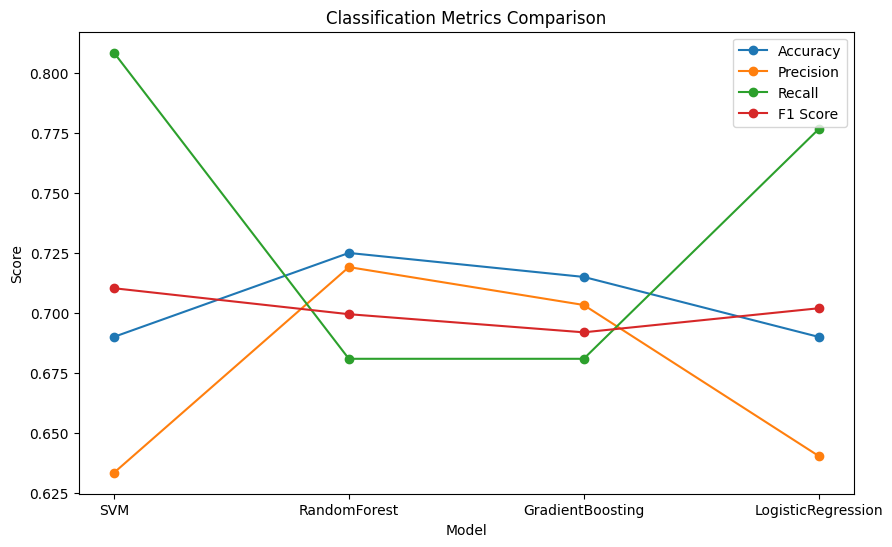

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc # Import roc_curve and auc
import matplotlib.pyplot as plt

trained_models = {
"SVM": svm,
"RandomForest": rf,
"GradientBoosting": grad_boost,
"LogisticRegression": lr
}
metrics = {}
for name, model in trained_models.items():
    # Evaluate model
    y_pred = model.predict(X_test) # Indented this line
    metrics[name] = {
    "Accuracy": accuracy_score(y_test, y_pred), # Indented this line
    "Precision": precision_score(y_test, y_pred), # Indented this line
    "Recall": recall_score(y_test, y_pred), # Indented this line
    "F1 Score": f1_score(y_test, y_pred) # Indented this line
    }
metrics_names = ["Accuracy", "Precision", "Recall", "F1 Score"]

# Plot classification metrics
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for metric in metrics_names:
    values = [metrics[model][metric] for model in trained_models.keys()]
    ax.plot(trained_models.keys(), values, marker='o', label=metric)
ax.set_title("Classification Metrics Comparison")
ax.set_xlabel("Model")
ax.set_ylabel("Score")
ax.legend()
plt.show()


In [ ]:
import seaborn as sns

print(metrics)
print(metrics['SVM'].values())

{'SVM': {'Accuracy': 0.69, 'Precision': 0.6333333333333333, 'Recall': 0.8085106382978723, 'F1 Score': 0.7102803738317757}, 'RandomForest': {'Accuracy': 0.725, 'Precision': 0.7191011235955056, 'Recall': 0.6808510638297872, 'F1 Score': 0.6994535519125683}, 'GradientBoosting': {'Accuracy': 0.715, 'Precision': 0.7032967032967034, 'Recall': 0.6808510638297872, 'F1 Score': 0.6918918918918919}, 'LogisticRegression': {'Accuracy': 0.69, 'Precision': 0.6403508771929824, 'Recall': 0.776595744680851, 'F1 Score': 0.7019230769230769}}
dict_values([0.69, 0.6333333333333333, 0.8085106382978723, 0.7102803738317757])


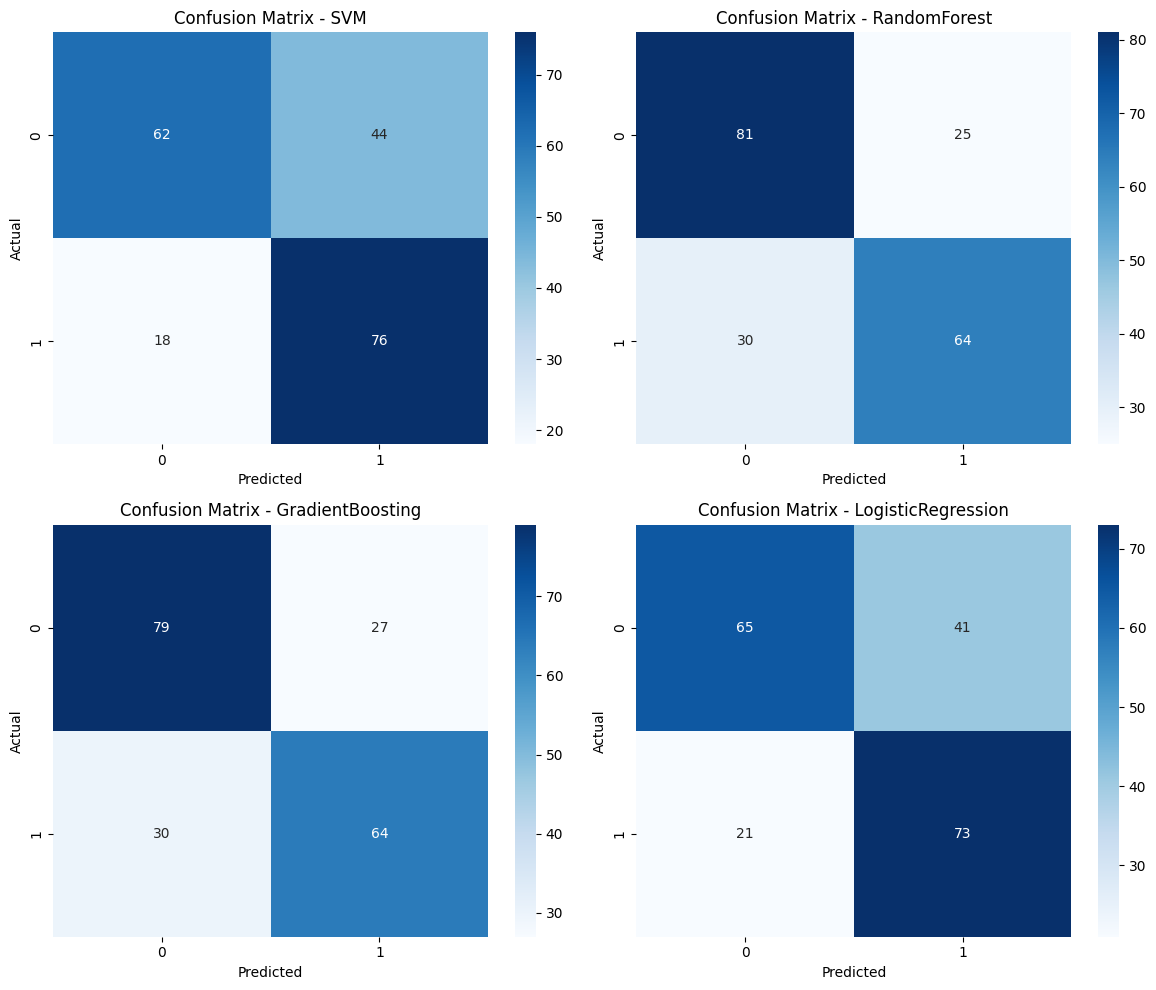

In [ ]:
# Plot Confusion Matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
for i, (name, model) in enumerate(trained_models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {name}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
plt.tight_layout()
plt.show()


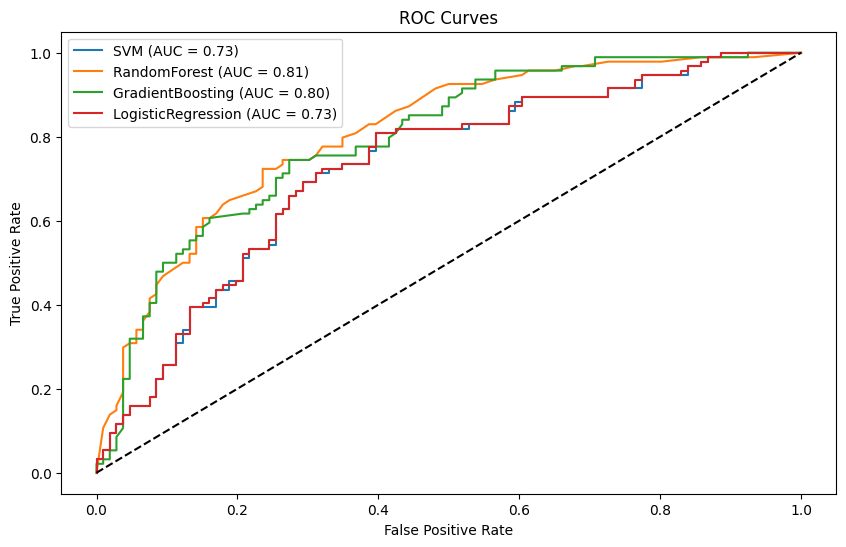

In [ ]:
# Plot ROC Curves
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for name, model in trained_models.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.decision_function(X_test) if hasattr(model, "decision_function") else model.predict(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves')
ax.legend()
plt.show()


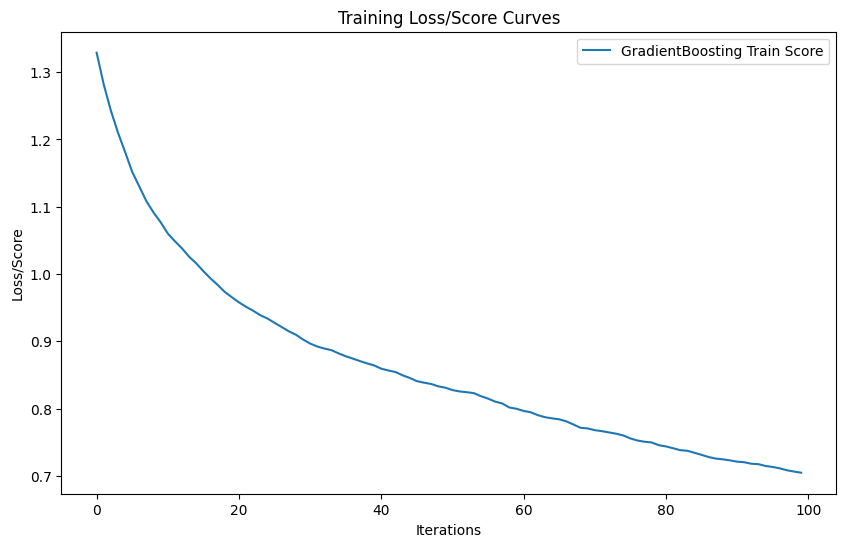

In [ ]:
# Plot Loss Curves (if applicable, for models with loss attributes)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for name, model in trained_models.items():
    if hasattr(model, 'loss_curve_'):
        ax.plot(model.loss_curve_, label=f'{name} Loss')
    elif hasattr(model, 'train_score_'):
        ax.plot(model.train_score_, label= f'{name} Train Score')

ax.set_xlabel('Iterations')
ax.set_ylabel('Loss/Score')
ax.set_title('Training Loss/Score Curves')
ax.legend()
plt.show()

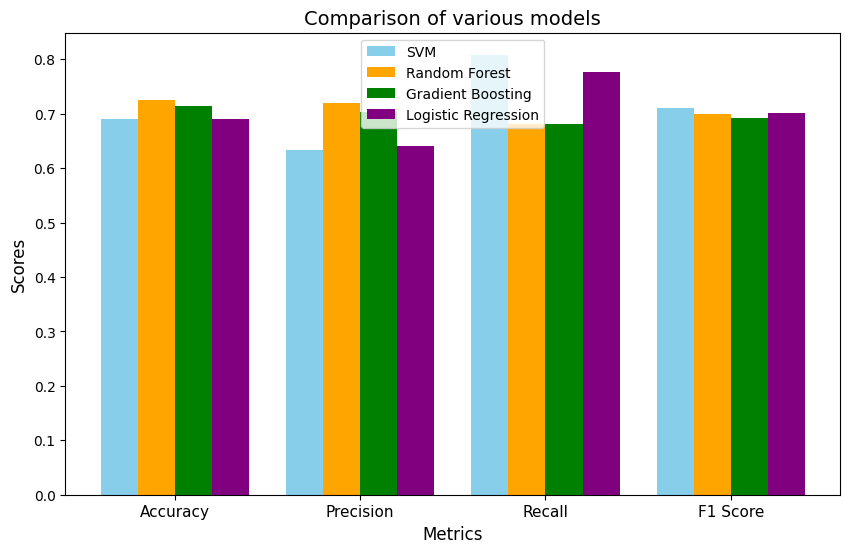

In [ ]:
# Plot the comparative bar graph
x = np.arange(len(metrics))
width = 0.2
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - 1.5 * width, metrics['SVM'].values(), width, label='SVM', color='skyblue')
bars2 = ax.bar(x - 0.5 * width, metrics['RandomForest'].values(), width, label='Random Forest', color='orange')
bars3 = ax.bar(x + 0.5 * width, metrics['GradientBoosting'].values(), width, label='Gradient Boosting', color='green')
bars4 = ax.bar(x + 1.5 * width, metrics['LogisticRegression'].values(), width, label='Logistic Regression', color='purple')
ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Scores', fontsize=12)
ax.set_title('Comparison of various models', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metrics_names, fontsize=11)
ax.legend()
plt.show()


<IPython.core.display.Javascript object>

Saved to photo.jpg


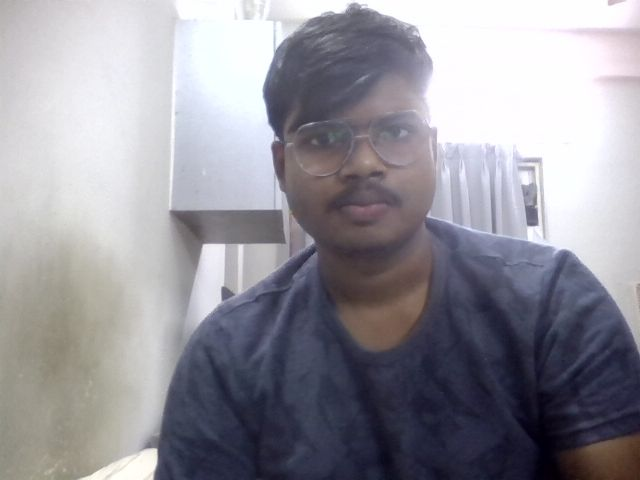

In [ ]:
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode


def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
    const div = document.createElement('div');
    const capture = document.createElement('button');
    capture.textContent = 'Capture';
    div.appendChild(capture);
    const video = document.createElement('video');
    video.style.display = 'block';
    const stream = await navigator.mediaDevices.getUserMedia({video: true});
    document.body.appendChild(div);
    div.appendChild(video);
    video.srcObject = stream;
    await video.play();
    // Resize the output to fit the video element.
    google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
    // Wait for Capture to be clicked.
    await new Promise((resolve) => capture.onclick = resolve);
    const canvas = document.createElement('canvas');
    canvas.width = video.videoWidth;
    canvas.height = video.videoHeight;
    canvas.getContext('2d').drawImage(video, 0, 0);
    stream.getVideoTracks()[0].stop();
    div.remove();
    return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename


from IPython.display import Image
try:
    filename = take_photo()
    print('Saved to {}'.format(filename))

    # Show the image which was just taken.
    display(Image(filename))
except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))

ALERT


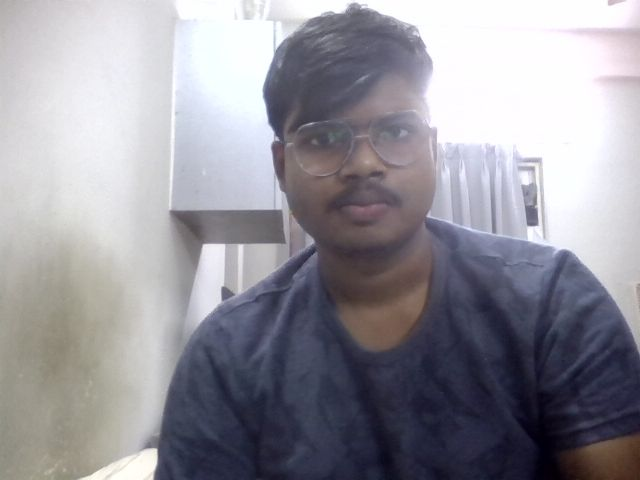

In [ ]:
import emoji

image = cv2.imread("photo.jpg")
features = extract_features(image)
#print(features)
if features:
    features = scaler.transform([features]) # Indented this line
#print(features)
# Check if features is not None and not nan
if features is not None and not np.isnan(features).any():
    prediction = svm.predict(features)
    label = "DROWSY " if prediction == 1 else "ALERT"
    print(label)
    color = (0, 0, 255) if prediction == 1 else (0, 255, 0)
    cv2.putText(frame, label, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    cv2_imshow(image)
else:
    print("Face not detected or features extraction failed.")